# Airbnb Analytics MVP

This notebook implements a lean Python MVP for Airbnb analytics:
- Optimize pricing
- Visualize the market
- Forecast revenue

Results are exported for integration with Next.js app.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [18]:
# Load data
# Note: Adjust paths if running from different directory
listings_df = pd.read_csv('../src/data/listings.csv')
calendar_df = pd.read_csv('../src/data/calendar.csv')

print('Listings shape:', listings_df.shape)
print('Calendar shape:', calendar_df.shape)
print('\nListings columns:', list(listings_df.columns))
print('\nCalendar columns:', list(calendar_df.columns))

Listings shape: (15187, 79)
Calendar shape: (5635043, 7)

Listings columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availa

In [19]:
# Data preprocessing

# Clean price columns
listings_df['price'] = listings_df['price'].str.replace('$', '').str.replace(',', '').astype(float)
calendar_df['price'] = calendar_df['price'].str.replace('$', '').str.replace(',', '').astype(float)
calendar_df['adjusted_price'] = calendar_df['adjusted_price'].str.replace('$', '').str.replace(',', '').astype(float)

# Convert date
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Handle missing values - drop rows with missing critical fields
listings_df = listings_df.dropna(subset=['price', 'accommodates', 'bedrooms', 'bathrooms'])
calendar_df = calendar_df.dropna(subset=['price', 'date', 'available'])

# Remove invalid prices (negative or zero)
listings_df = listings_df[listings_df['price'] > 0]
calendar_df = calendar_df[calendar_df['price'] > 0]
calendar_df = calendar_df[calendar_df['adjusted_price'] > 0]

# Remove duplicates
listings_df = listings_df.drop_duplicates(subset=['id'])
calendar_df = calendar_df.drop_duplicates(subset=['listing_id', 'date'])

# Outlier removal using IQR method (more robust than percentile)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to price columns
listings_df = remove_outliers_iqr(listings_df, 'price')
calendar_df = remove_outliers_iqr(calendar_df, 'price')
calendar_df = remove_outliers_iqr(calendar_df, 'adjusted_price')

# Additional cleaning for listings
listings_df = listings_df[listings_df['accommodates'] > 0]
listings_df = listings_df[listings_df['minimum_nights'] >= 1]
listings_df = listings_df[listings_df['maximum_nights'] <= 365]

print('After cleaning - Listings shape:', listings_df.shape)
print('After cleaning - Calendar shape:', calendar_df.shape)
print('Price range - Listings:', f"${listings_df['price'].min():.2f} - ${listings_df['price'].max():.2f}")
print('Price range - Calendar:', f"${calendar_df['price'].min():.2f} - ${calendar_df['price'].max():.2f}")


After cleaning - Listings shape: (7304, 79)
After cleaning - Calendar shape: (4467, 7)
Price range - Listings: $9.00 - $454.00
Price range - Calendar: $776.00 - $5000.00


## Pricing Optimization

Use linear regression to predict optimal price based on property features.

In [20]:
# Prepare features for pricing model
features = ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights']
X = listings_df[features].fillna(0)
y = listings_df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: ${rmse:.2f}')
print('Model coefficients:')
for feature, coef in zip(features, model.coef_):
    print(f'{feature}: ${coef:.2f}')

RMSE: $69.48
Model coefficients:
accommodates: $8.84
bedrooms: $6.65
bathrooms: $29.77
beds: $3.32
minimum_nights: $-0.30
maximum_nights: $-0.04


## Market Visualization

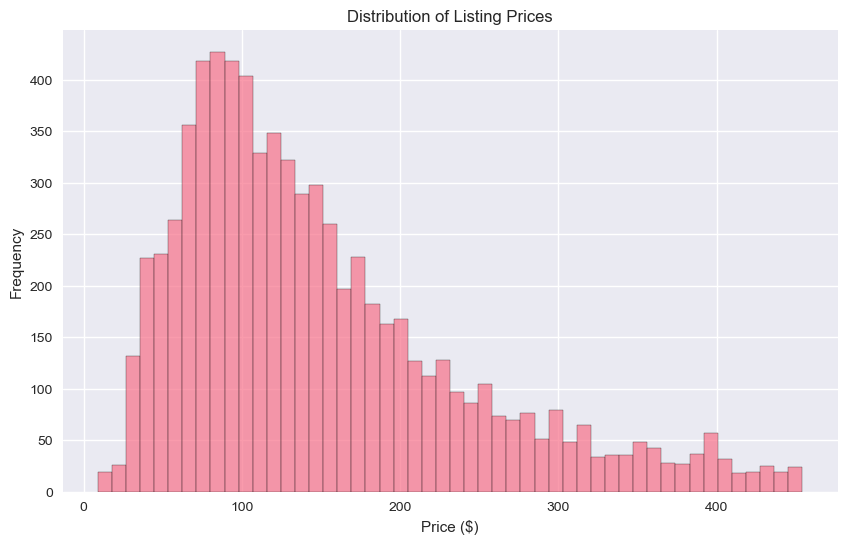

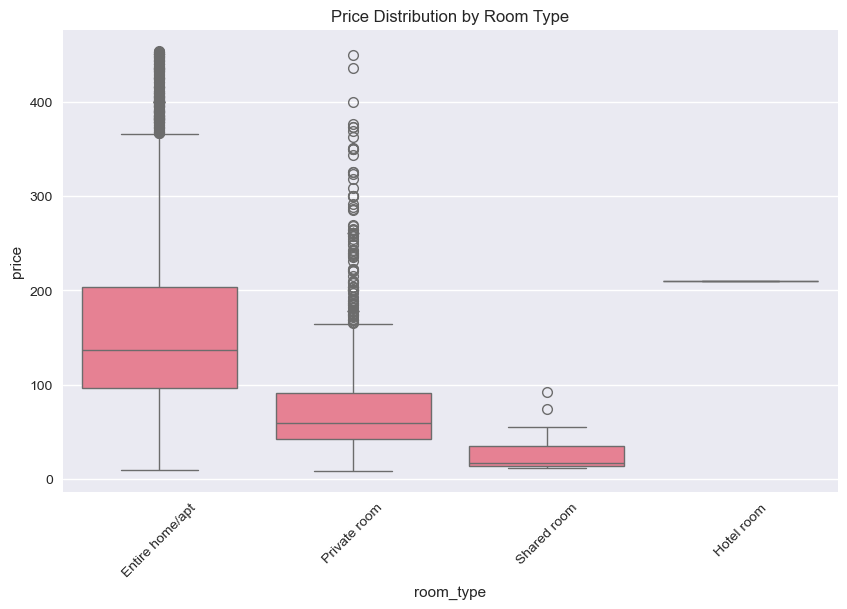

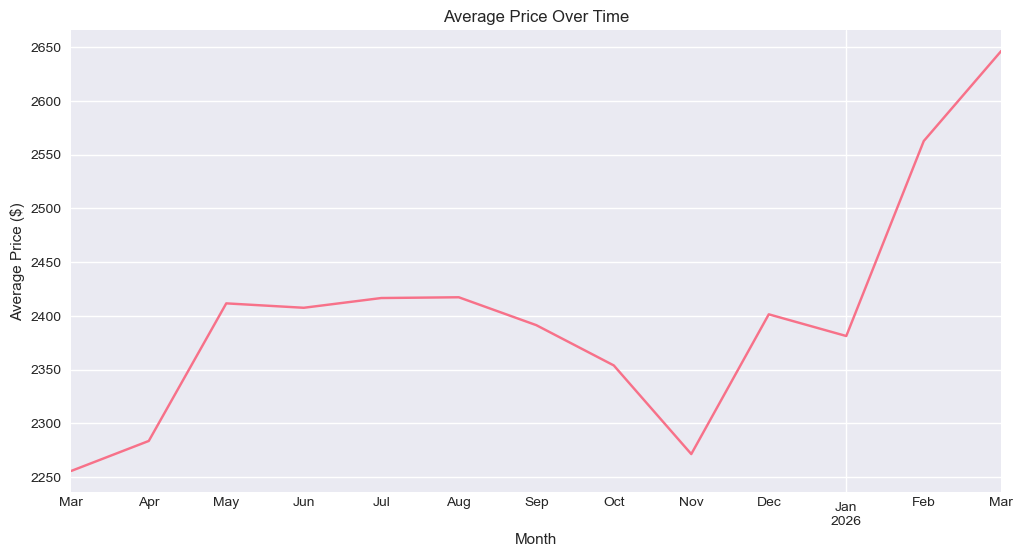

In [21]:
# Price distribution
plt.figure(figsize=(10, 6))
plt.hist(listings_df['price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Listing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

# Price by room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=listings_df)
plt.title('Price Distribution by Room Type')
plt.xticks(rotation=45)
plt.show()

# Average price over time
monthly_avg = calendar_df.groupby(calendar_df['date'].dt.to_period('M'))['price'].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot()
plt.title('Average Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.show()

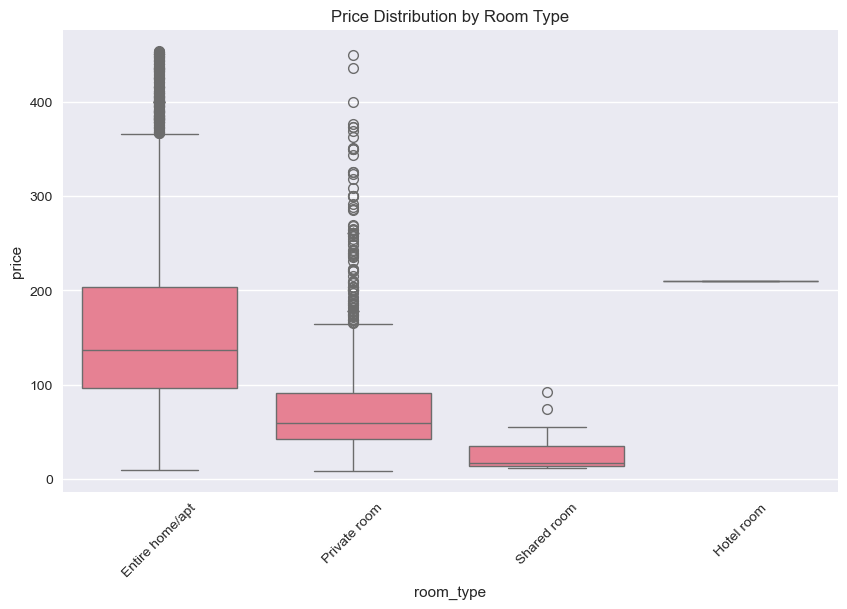

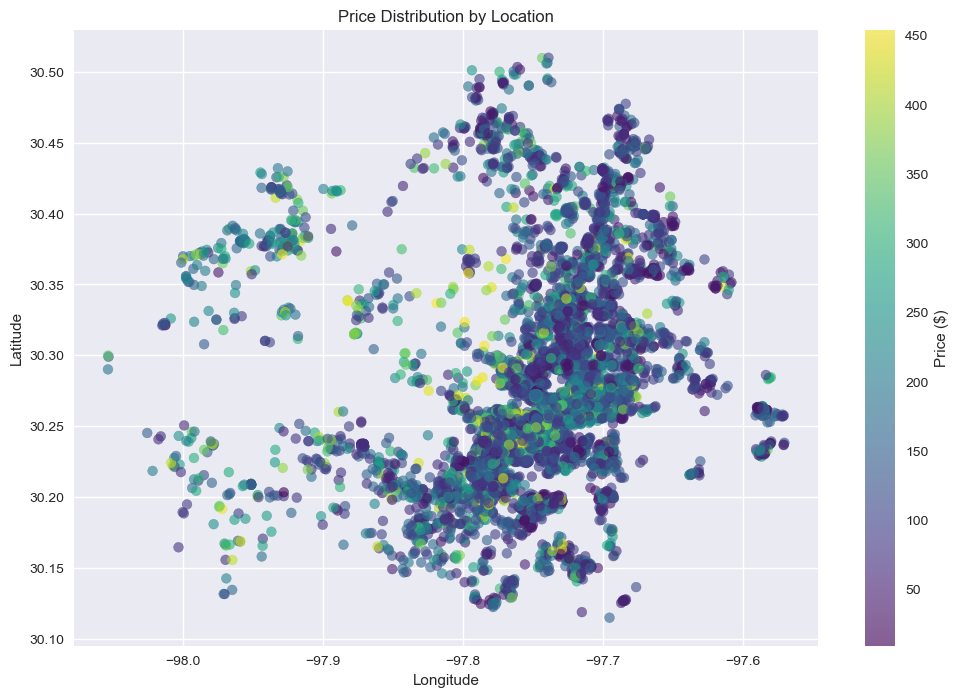

Top 10 most expensive neighborhoods:
                              mean  count         std
neighbourhood_cleansed                               
78732                   233.625000     24   96.767679
78733                   218.270270     37  109.949395
78746                   214.125000     88  121.939104
78734                   198.926174    149   94.454629
78701                   197.101818    550   81.163739
78737                   193.252747     91  106.811838
78736                   192.729167     48  105.530018
78730                   180.727273     11  139.673971
78703                   176.073846    325   98.831354
78702                   171.255629    755   94.575105


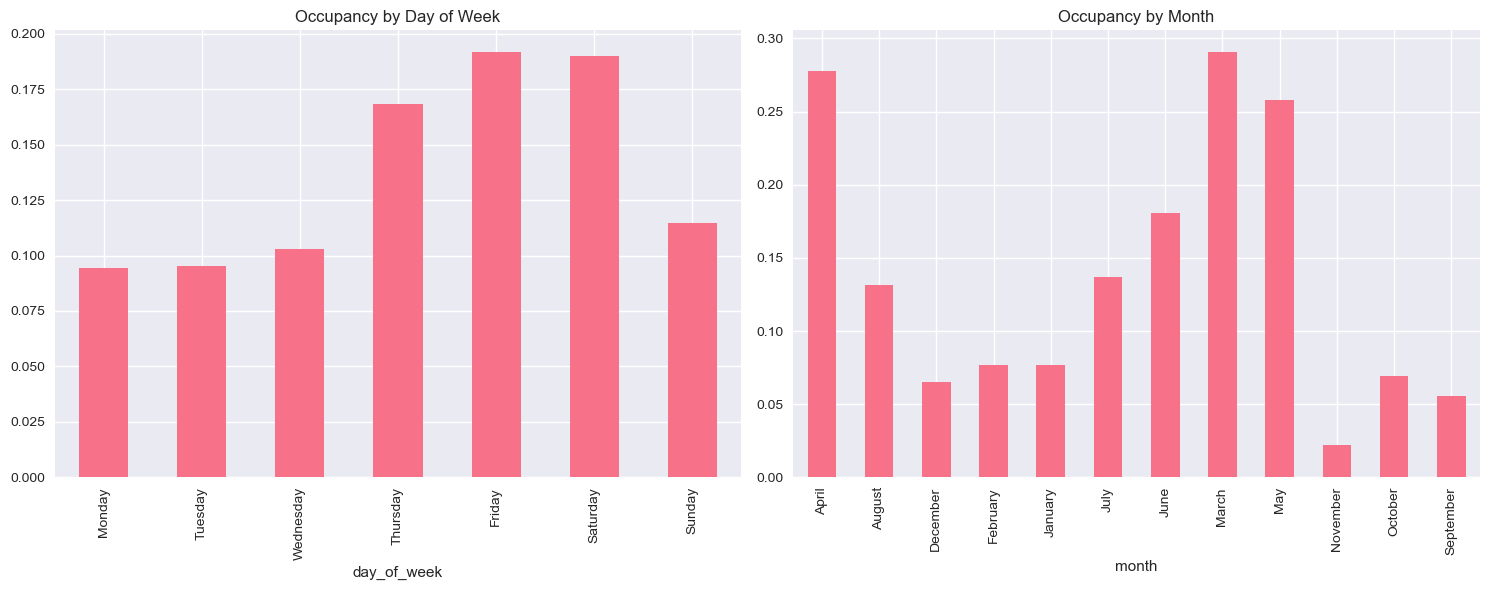

In [29]:
# Price by room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=listings_df)
plt.title('Price Distribution by Room Type')
plt.xticks(rotation=45)
plt.show()

# Price by location
plt.figure(figsize=(12, 8))
plt.scatter(listings_df['longitude'], listings_df['latitude'], 
           c=listings_df['price'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(label='Price ($)')
plt.title('Price Distribution by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Average price by neighborhood
neighborhood_avg = listings_df.groupby('neighbourhood_cleansed')['price'].agg(['mean', 'count', 'std'])
neighborhood_avg = neighborhood_avg[neighborhood_avg['count'] > 10].sort_values('mean', ascending=False)
print("Top 10 most expensive neighborhoods:")
print(neighborhood_avg.head(10))

# Daily occupancy patterns
calendar_df['day_of_week'] = calendar_df['date'].dt.day_name()
calendar_df['month'] = calendar_df['date'].dt.month_name()

weekly_pattern = calendar_df.groupby('day_of_week')['occupied'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
monthly_pattern = calendar_df.groupby('month')['occupied'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
weekly_pattern.plot(kind='bar', ax=ax1, title='Occupancy by Day of Week')
monthly_pattern.plot(kind='bar', ax=ax2, title='Occupancy by Month')
plt.tight_layout()
plt.show()


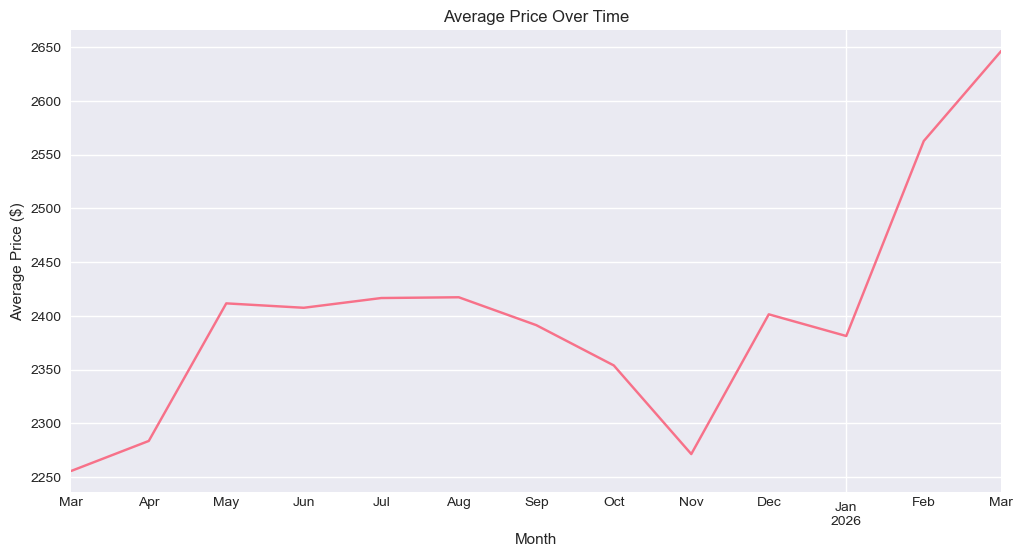

Top 20 most common amenities:
Smoke alarm: 7077
Kitchen: 6735
Wifi: 6589
Hot water: 6110
Carbon monoxide alarm: 5944
Dishes and silverware: 5817
Fire extinguisher: 5637
Microwave: 5634
Hair dryer: 5566
Bed linens: 5552
Cooking basics: 5521
Hangers: 5507
Self check-in: 5453
Essentials: 5339
Refrigerator: 5276
Free parking on premises: 5267
Iron: 5226
Dedicated workspace: 5140
Air conditioning: 5075
Shampoo: 5021
Smoke alarm: +9.3% price premium
Kitchen: +45.7% price premium
Wifi: +-0.8% price premium
Hot water: +0.1% price premium
Carbon monoxide alarm: +18.6% price premium
Dishes and silverware: +13.1% price premium
Fire extinguisher: +17.7% price premium
Microwave: +8.4% price premium
Hair dryer: +20.7% price premium
Bed linens: +12.4% price premium


In [30]:
# Average price over time
monthly_avg = calendar_df.groupby(calendar_df['date'].dt.to_period('M'))['price'].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot()
plt.title('Average Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.show()


from collections import Counter
import ast

# Parse amenities (assuming it's stored as string list)
listings_df['amenities_list'] = listings_df['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Most common amenities
all_amenities = [amenity for sublist in listings_df['amenities_list'] for amenity in sublist]
amenity_counts = Counter(all_amenities)
print("Top 20 most common amenities:")
for amenity, count in amenity_counts.most_common(20):
    print(f"{amenity}: {count}")

# Price impact of top amenities
top_amenities = [amenity for amenity, _ in amenity_counts.most_common(10)]
for amenity in top_amenities:
    with_amenity = listings_df[listings_df['amenities_list'].apply(lambda x: amenity in x)]['price'].mean()
    without_amenity = listings_df[listings_df['amenities_list'].apply(lambda x: amenity not in x)]['price'].mean()
    price_diff = ((with_amenity - without_amenity) / without_amenity) * 100
    print(f"{amenity}: +{price_diff:.1f}% price premium")

## Revenue Forecasting

Simple forecasting based on historical occupancy and pricing.

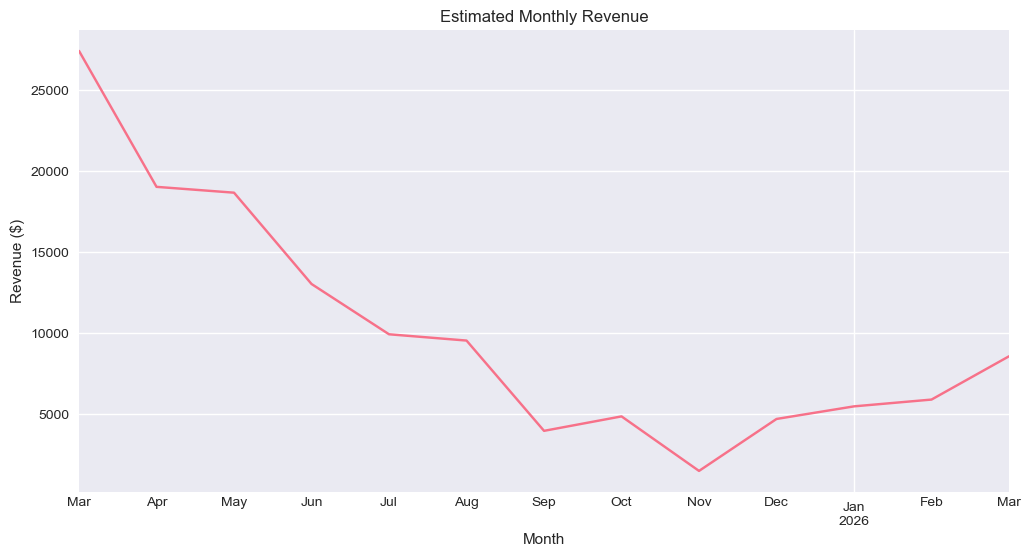

Average monthly revenue: 10209.824747448187
Top hosts by listing count:
           avg_price  listing_count  avg_rating  total_reviews
host_id                                                       
18253226      183.70             74        4.69           2594
274552333      89.85             52        4.64           1367
518041117     195.43             49         NaN              0
447606169     185.19             43        4.71            559
461521204      76.51             39        4.67           1184
114422088     162.16             38        4.93           1303
30225950      181.86             37        4.72            704
411546857     238.90             29        5.00             16
5834228        78.04             28        4.79           4385
674385855      67.57             28        4.39             46

Superhost vs Regular Host Comparison:
                        price  review_scores_rating  availability_365
host_is_superhost                                              

In [31]:
# Calculate occupancy rate
calendar_df['occupied'] = calendar_df['available'] == 'f'
occupancy_rate = calendar_df.groupby(calendar_df['date'].dt.to_period('M'))['occupied'].mean()

# Calculate potential revenue
monthly_revenue = monthly_avg * occupancy_rate * 30  # Assuming 30 days per month

plt.figure(figsize=(12, 6))
monthly_revenue.plot()
plt.title('Estimated Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.show()

print('Average monthly revenue:', monthly_revenue.mean())


# Host metrics
host_stats = listings_df.groupby('host_id').agg({
    'price': ['mean', 'count'],
    'review_scores_rating': 'mean',
    'number_of_reviews': 'sum'
}).round(2)

host_stats.columns = ['avg_price', 'listing_count', 'avg_rating', 'total_reviews']
host_stats = host_stats.sort_values('listing_count', ascending=False)

print("Top hosts by listing count:")
print(host_stats.head(10))

# Superhost vs regular host comparison
superhost_stats = listings_df.groupby('host_is_superhost').agg({
    'price': 'mean',
    'review_scores_rating': 'mean',
    'availability_365': 'mean'
})
print("\nSuperhost vs Regular Host Comparison:")
print(superhost_stats)

## Export Results for Next.js Integration

In [32]:
# Export key metrics to JSON
results = {
    'average_price': listings_df['price'].mean(),
    'median_price': listings_df['price'].median(),
    'total_listings': len(listings_df),
    'occupancy_rate': occupancy_rate.mean(),
    'average_monthly_revenue': monthly_revenue.mean(),
    'pricing_model_rmse': rmse,
    'model_coefficients': dict(zip(features, model.coef_))
}

import json
with open('analytics_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print('Results exported to analytics_results.json')
print(json.dumps(results, indent=2))


# Price elasticity analysis
listings_df['price_category'] = pd.qcut(listings_df['price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

occupancy_by_price = listings_df.groupby('price_category').agg({
    'availability_365': lambda x: (365 - x).mean(),  # Estimated annual occupancy
    'review_scores_rating': 'mean'
})

print("Occupancy and Rating by Price Category:")
print(occupancy_by_price)

# Revenue optimization
occupancy_by_price['estimated_revenue'] = occupancy_by_price['availability_365'] * listings_df.groupby('price_category')['price'].mean()
print("\nEstimated Annual Revenue by Price Category:")
print(occupancy_by_price['estimated_revenue'])


Results exported to analytics_results.json
{
  "average_price": 149.74958926615554,
  "median_price": 126.0,
  "total_listings": 7304,
  "occupancy_rate": 0.14342787246111363,
  "average_monthly_revenue": 10209.824747448187,
  "pricing_model_rmse": 69.47882692812506,
  "model_coefficients": {
    "accommodates": 8.837043028474058,
    "bedrooms": 6.646830890139013,
    "bathrooms": 29.765826357507343,
    "beds": 3.315951118319954,
    "minimum_nights": -0.30031953753081475,
    "maximum_nights": -0.03633479432127906
  }
}
Occupancy and Rating by Price Category:
                availability_365  review_scores_rating
price_category                                        
Very Low              153.110129              4.756913
Low                   141.813922              4.817409
Medium                137.191848              4.851622
High                  134.280380              4.869455
Very High             141.574498              4.893244

Estimated Annual Revenue by Price Category:
p

Sample data exported for Next.js integration


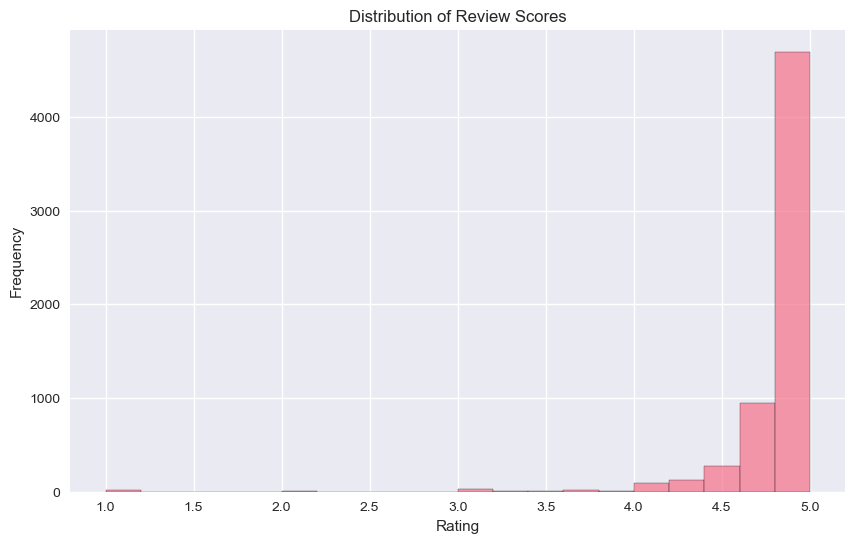

Correlations with Review Scores:
review_scores_rating    1.000000
price                   0.126024
bedrooms                0.064248
bathrooms               0.063349
accommodates            0.027114
Name: review_scores_rating, dtype: float64


In [33]:
# Export processed data for visualization
listings_export = listings_df[['id', 'name', 'room_type', 'price', 'accommodates', 'bedrooms', 'bathrooms']].head(100)
listings_export.to_csv('listings_sample.csv', index=False)

calendar_export = calendar_df.groupby(calendar_df['date'].dt.to_period('M')).agg({
    'price': 'mean',
    'occupied': 'mean'
}).reset_index()
calendar_export['date'] = calendar_export['date'].astype(str)
calendar_export.to_csv('monthly_stats.csv', index=False)

print('Sample data exported for Next.js integration')

# Rating distribution
plt.figure(figsize=(10, 6))
plt.hist(listings_df['review_scores_rating'].dropna(), bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribution of Review Scores')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Correlation between ratings and other factors
rating_corr = listings_df[['review_scores_rating', 'price', 'accommodates', 'bedrooms', 'bathrooms']].corr()
print("Correlations with Review Scores:")
print(rating_corr['review_scores_rating'].sort_values(ascending=False))
